## Link Drive & import libs

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Libraries

In [8]:
import os
import time
import json
import pickle
import random
import zipfile
import collections
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

## Init base path (for selecting Model)

In [9]:
max_length = 49  # maximum length of any caption in MS-COCO
m_path = os.path.abspath('drive/MyDrive/model_data_MS_E35_B256')

# max_length = 28  # maximum length of any caption in Flickr8k
# m_path = os.path.abspath('drive/MyDrive/model_data_Flick_E35_B128')

print('Base path:', m_path)
# Ex: C:\Users\Sami\Faculty of Information Technology\Fifth_Year

Base path: /content/drive/MyDrive/model_data_MS_E35_B256


## Model components

In [10]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

Preprocess the images using InceptionV3

In [11]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


In [12]:
# Choose the top 5000 words from the vocabulary
top_k = 10000
if os.path.isdir(m_path + '/model_data') and os.path.isfile(m_path + '/model_data/tokenizer.pickle'):
  with open(m_path + '/model_data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    print('Tokenizer is loaded!')
else:
  raise Exception('Couldn\'t find Tokenizer file at ' + m_path + '/model_data/tokenizer.pickle')

Tokenizer is loaded!


Create a tf.data Dataset for training ($)

In [13]:
embedding_dim = 256
units = 512
vocab_size = top_k + 1

# Shape of the vector extracted from InceptionV3 is (64, 2048)
attention_features_shape = 64

Model

In [14]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [15]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [16]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

## Loading Model (for selecting a specified epoch)

In [17]:
enc_dec_num = '34'

if os.path.isfile(f'{m_path}/model_data/encoder{enc_dec_num}.weights.index') and os.path.isfile(f'{m_path}/model_data/decoder{enc_dec_num}.weights.index'):
  encoder = CNN_Encoder(embedding_dim)
  decoder = RNN_Decoder(embedding_dim, units, vocab_size)
  encoder.load_weights(f'{m_path}/model_data/encoder{enc_dec_num}.weights')
  decoder.load_weights(f'{m_path}/model_data/decoder{enc_dec_num}.weights')
  print('encoder/decode are loaded!')
else:
  raise Exception(f'encoder{enc_dec_num}/decoder{enc_dec_num} not found!')

encoder/decode are loaded!


### Continue Loading Model Components

In [18]:
optimizer = tf.keras.optimizers.Adam()

Checkpoint ($)

In [19]:
if not os.path.isdir(m_path + '/model_data'):
  raise Exception('model_data folder is missing!')
checkpoint_path = m_path + "/model_data/checkpoints"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=50)

In [20]:
last_epoch = 0
if ckpt_manager.latest_checkpoint:
  print(f'last checkpoint {ckpt_manager.latest_checkpoint}')
  last_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)
print('starting model from epoch:', last_epoch)

last checkpoint /content/drive/MyDrive/model_data_MS_E35_B256/model_data/checkpoints/ckpt-35
starting model from epoch: 35


## Testing

### Testing utils

In [21]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [22]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Test on a validatoin image (may i'll use this for Bleu score)

In [23]:
# # captions on the validation set
# rid = np.random.randint(0, len(img_name_val))
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i]
#                         for i in cap_val[rid] if i not in [0]])
# result, attention_plot = evaluate(image)

# print('Real Caption:', real_caption)
# print('Prediction Caption:', ' '.join(result))
# plot_attention(image, result, attention_plot)
# Image.open(image)

In [24]:
def predict_url_image(image_url):
  image_name_extension = image_url.split('/')[-1]
  print(image_name_extension)
  image_path = tf.keras.utils.get_file(image_name_extension, origin=image_url, cache_subdir='/content')
  result, attention_plot = evaluate(image_path)
  return image_path, result, attention_plot

### Test on any image

In [25]:
# url = 'https://ichef.bbci.co.uk/news/873/cpsprodpb/2F0D/production/_118054021_1afcbf08-6b32-4d75-9cca-783d61d7b94f.jpg'
# url = 'https://www.esafety.gov.au/sites/default/files/2019-08/Remove%20images%20and%20video.jpg'
# url = 'https://i2.wp.com/digital-photography-school.com/wp-content/uploads/2016/02/Headshot-Photography-London-1052.jpeg'
url = 'https://i.chzbgr.com/original/3933445/h5ABCC7A5/just-20-random-animal-photos-that-will-make-you-scratch-your-head'
# url = 'https://image.shutterstock.com/image-photo/action-hero-muscled-man-holding-260nw-196778930.jpg'
# url = 'https://d28m5bx785ox17.cloudfront.net/v1/img/_E0oIsccZlmMAfrWZNVRGl4yaIYZRD2RiHCXgJFMIjc=/d/l'
# url = 'https://images.unsplash.com/photo-1496181133206-80ce9b88a853'
# url = 'https://thumbor.forbes.com/thumbor/fit-in/x/https://www.forbes.com/advisor/wp-content/uploads/2021/06/inground-pool.jpeg'
# url = 'https://riverdalepress.com/uploads/original/1470848884_42a8.jpg'
# url = 'https://bestsellingcarsblog.com/wp-content/uploads/2019/06/Shanghai-Street-3.jpg'
# url = 'https://i.pinimg.com/originals/d0/0d/bd/d00dbde1ddf6ff4060aa183600900f8b.jpg'
# url = 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/kitchen-decor-ideas-1580491833.jpg?crop=1.00xw:0.669xh;0,0.151xh&resize=640:*'
# url = 'https://c8.alamy.com/comp/X7M18P/lecturer-and-students-in-a-university-amphitheatre-classroom-X7M18P.jpg'

just-20-random-animal-photos-that-will-make-you-scratch-your-head
73728/64825 [==================================] - 0s 0us/step
Prediction Caption: كلب صغير يقف في العشب في حقل أخضر مورق يجلسان على العشب حولها <end>


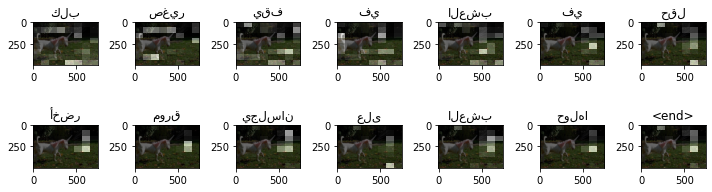

In [26]:
image_path, result, attention_plot = predict_url_image(url)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
# Image.open(image_path)

## Metrics

In [27]:
m_path = os.path.abspath('')

### Bleu 1

Download Arabic Captions

In [28]:
if not os.path.isfile(m_path + '/ar_captions_train2014.json'):
  print('downloading arabic captions....')
  annotation_file = tf.keras.utils.get_file('ar_captions_train2014.json',
                                            cache_subdir= m_path,
                                            origin='https://github.com/canesee-project/Arabic-COCO/raw/master/ar_captions_train2014.json')
else:
  print('Arabic captions file is already downloaded!')

downloading arabic captions....
77774848/77760141 [==============================] - 1s 0us/step


Download MS-COCO images dataset

In [29]:
if not os.path.isfile(m_path + '/train2014.zip'):
  print('downloading MS-COCO dataset....')
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir= m_path,
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=False)
else:
  print('MS-COCO dataset is already downloaded!')

downloading MS-COCO dataset....
13510582272/13510573713 [==============================] - 375s 0us/step


In [30]:
if not os.path.isdir(m_path + '/train2014'):
  print('unzipping dataset.....')
  with zipfile.ZipFile(m_path + '/train2014.zip', 'r') as zip_ref:
    zip_ref.extractall(m_path)

unzipping dataset.....


Init Images & annotations dictionary

In [31]:
with open(m_path + '/ar_captions_train2014.json', 'r') as f:
    annotations = json.load(f)

# Group all captions together having the same image ID.
PATH = m_path + '/train2014/'
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [32]:
print(len(image_path_to_caption))

82783


Limit Training Images ($)

In [33]:
image_paths = list(image_path_to_caption.keys())
random.seed(4)
random.shuffle(image_paths)

# train_image_paths = image_paths[:10]
train_image_paths = image_paths
print('training images count:', len(train_image_paths))

train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

training images count: 82783


Tokenize the captions ($)

In [34]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

Split the data into training and testing

In [35]:
# Create training and validation sets using an 80-20 split randomly.
img_keys = list(set(image_path_to_caption.keys()))
random.seed(4)
random.shuffle(img_keys)
print(len(img_keys))
slice_index = int(len(img_keys)*0.8)
img_name_val_keys = img_keys[slice_index:]
print(len(img_name_val_keys))

82783
16557


In [36]:
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
def remove_punc(string):
  return "".join(ch for ch in string if ch not in punc)

In [ ]:
# captions on the validation set
hypotheses = []
list_of_references = []
for img in img_name_val_keys:
  # Prediction
  result, _ = evaluate(img)
  hypotheses.append(result[:-1])
  # Real captions
  refs = list()
  captions = image_path_to_caption[img]
  for caption in captions:
    caption = remove_punc(caption)
    ref = caption.split(' ')[1:-1]
    refs.append(ref)
  list_of_references.append(refs)

# print("hyp:")
# for hyp in hypotheses:
#   print(hyp)

# print('refs:')
# for r in list_of_references: 
#   print('ref:')
#   for rr in r:
#     print(rr)

In [50]:
len(hypotheses)

7640

In [51]:
from nltk.translate import bleu_score
# Bleu-1
BLEUscore = bleu_score.corpus_bleu(list_of_references, hypotheses, weights=(1, 0, 0, 0))
print(BLEUscore)

0.36409453694784644


In [52]:
# Bleu-2
BLEUscore = bleu_score.corpus_bleu(list_of_references, hypotheses, weights=(0, 1, 0, 0))
print(BLEUscore)

0.13319603144741268


In [53]:
# Bleu-3
BLEUscore = bleu_score.corpus_bleu(list_of_references, hypotheses, weights=(0, 0, 1, 0))
print(BLEUscore)

0.04727018198786748


In [54]:
# Bleu-4
BLEUscore = bleu_score.corpus_bleu(list_of_references, hypotheses, weights=(0, 0, 0, 1))
print(BLEUscore)

0.017387111413660082
